# Markov Chain Monte Carlo

The primary goal of Markov Chain Monte Carlo is to draw samples from some distribution p which is unknown, and usually hard to compute analytically (due to high dimensionality or other factors)

This method relies on key principles from Monte Carlo methods and Markov chains, hence the name.

## Background: Monte Carlo

Monte Carlo methods are a family of algorithms that rely on repeated random sampling to obtain numerical results.
The philosophy is that an analytical/exact solution may be hard to compute, but by randomly sampling from a distribution over the domain and performing a computation on the outputs, the aggregate of the outputs approaches the exact solution.

### Demo 1: Weird distribution

Suppose we have some random variable $X,Y,Z\sim Uniform(0,1)$. What is the distribution of $T=(XY)^{Z}$?

An analytical solution to this problem exists, and in fact $(XY)^{Z}\sim Uniform(0,1)$! But because we are data scientists, we are lazy and want a "good enough" proof for this. We apply the Monte Carlo method:
1. Generate a large number of samples from $X,Y,Z$.
2. For each $x_i\in X, y_i\in Y, z_i\in Z$, compute $t_i^* = (x_iy_i)^{z_i}$
3. As sample size increases, the probability mass of $T^*$ eventually plot the distribution of $T$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Sample coordinates from [-1,1]
x = np.random.uniform(0,1,100000)
y = np.random.uniform(0,1,100000)
z = np.random.uniform(0,1,100000)

# If a point satisfies x^2 + y^2 < 1 then it is in the circle.
t = (x*y)**z

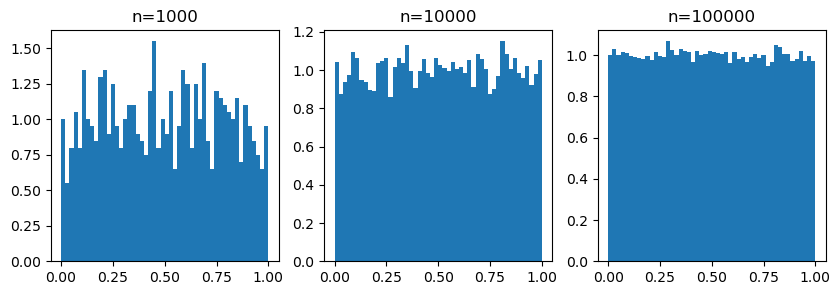

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10,3))
ax[0].hist(t[:1000],50, density = True)
ax[1].hist(t[:10000],50, density = True)
ax[2].hist(t,50, density = True)

ax[0].set_title("n=1000")
ax[1].set_title("n=10000")
ax[2].set_title("n=100000")

plt.show()

An important conclusion to be drawn here is that not only does $T^* \sim T$, all generated samples $t_i$ from this method is essentially the same as drawing samples from $T$.

But what happens if we don't know the exact parameters of $X,Y,Z$?

## Background: Markov Chain

A Markov Chain is a type of stochastic process in which the probability of an event occurring at time $t+1$ only depends on the state achieved at time $t$.
The property of Markov Chains that MCMC primarily uses is the stationary distribution: given transition matrix $P$ and initial distribution $\pi = (\pi_1,\pi_2,...)$ , then $\pi P=\pi$ .

### Demo 2: Stationary Distributions

Suppose you have a population divided into two groups: people living in city A, and people living in City B. Every year, 10% of the people living in city A move to city B, while 15% of the people living in city B move to city A. Yet the population of the two cities stays the same? What are the proportions of people live in city A and B?

In [4]:
initial = [0.5, 0.5]

transition = np.array([[.9,.1],[.15,.85]])

In [5]:
# After 3 steps in the markov chain
initial@np.linalg.matrix_power(transition, 3)

array([0.5578125, 0.4421875])

In [6]:
# After 10 steps in the markov chain
initial@np.linalg.matrix_power(transition, 10)

array([0.59436865, 0.40563135])

In [7]:
# After 100 steps in the markov chain
initial@np.linalg.matrix_power(transition, 100)

array([0.6, 0.4])

In [8]:
# Confirm that (.6, .4) is the stationary distribution
[0.6, 0.4]@transition

array([0.6, 0.4])

Note that once we reach the stationary distribution, we will stay in it forever. This is **extremely important to MCMC**!

## Inverse CDF sampling

When an analytical form of the cumulative distribution function $F_X$ exists and its inverse can be calculated, then we can samples $u$ from $Unif(0,1)$ and calculate $F^{-1}_X(u)$ to gain samples from $X$.

In [9]:
import scipy.stats as sp

In [10]:
u = np.random.uniform(0,1,10000)
x = -0.2*np.log(1-u)

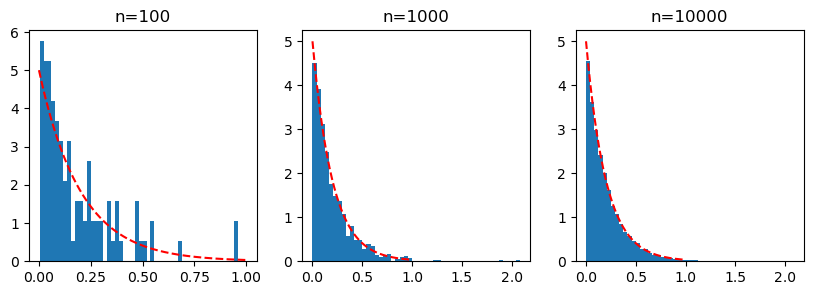

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10,3))
ax[0].hist(x[:100],50, density = True)
ax[0].plot(np.linspace(0,1,600),5*np.exp(-5*np.linspace(0,1,600)),color='red', ls='--')
ax[1].hist(x[:1000],50, density = True)
ax[1].plot(np.linspace(0,1,600),5*np.exp(-5*np.linspace(0,1,600)),color='red', ls='--')
ax[2].hist(x,50, density = True)
ax[2].plot(np.linspace(0,1,600),5*np.exp(-5*np.linspace(0,1,600)),color='red', ls='--')

ax[0].set_title("n=100")
ax[1].set_title("n=1000")
ax[2].set_title("n=10000")

plt.show()

## Rejection sampling and its drawbacks

One of the approaches to sampling from some random variable $X$ with density $f$ if sampling direcly is too challenging is the rejection sampling method:
1. Sample $y$ from an easier distribution $Y$ with density $g$
2. Sample $u$ from $Unif(0,1)$
3. Check if $u<f(y)/Mg(y)$, where M is a constant such that $Mg(y)\ge f(y)$ for all $y$. If this holds, accept it as a sample drawn from $X$. If not, reject it and begin again.

On average, the algorithm takes $M$ iterations to obtain a sample. Therefore, if $f$ is too complex or $g$ is poorly chosen, it can take MANY iterations to get the desired sample.

### Demo: Bad rejection sampling

Suppose we have target distribution $X$ defined by a density function $f=e^{-\pi x^2}$ which we wish to sample from.

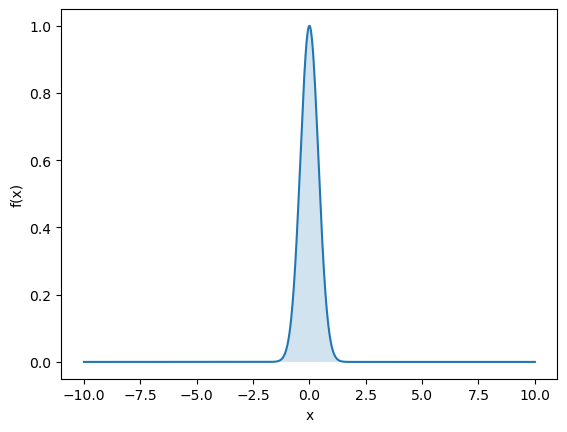

In [12]:
def gauss(x):
    return np.exp(-np.pi * x**2)

xs = np.linspace(-10, 10, 1000)
ys = gauss(xs)

plt.plot(xs, ys)
plt.fill_between(xs, ys, 0, alpha=0.2)
plt.xlabel("x"), plt.ylabel("f(x)");

Efficiency is only 5.2%


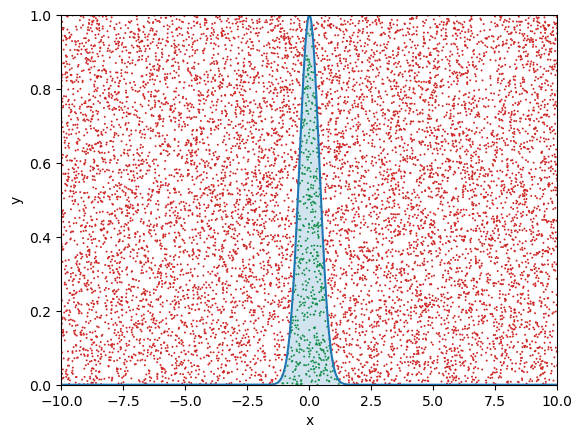

In [13]:
def batch_sample_2(function, num_samples, xmin=-10, xmax=10, ymax=1):
    x = np.random.uniform(low=xmin, high=xmax, size=num_samples)
    y = np.random.uniform(low=0, high=ymax, size=num_samples)
    passed = (y < function(x)).astype(int)
    return x, y, passed

x, y, passed = batch_sample_2(gauss, 10000)

plt.plot(xs, ys)
plt.fill_between(xs, ys, 0, alpha=0.2)
plt.scatter(x, y, c=passed, cmap="RdYlGn", vmin=-0.1, vmax=1.1, lw=0, s=2)
plt.xlabel("x"), plt.ylabel("y"), plt.xlim(-10, 10), plt.ylim(0, 1);

print(f"Efficiency is only {passed.mean() * 100:0.1f}%")

## Metropolis-Hastings

We are now ready to tackle MCMC. As seen from above, rejection sampling was very inefficient. This is due to the key insight that **samples were drawn independently from one another**. MCMC instead introduces autocorrelation in order to encode the information that the sampler should explore areas around high-acceptance points.


The Metropolis-Hastings algorithm is as follows:
1. Pick an initial state $x_0$, set $t=0$
2. Generate a random candidate $x'$ according to $g(x'|x)$
3. Calculate the acceptance probability $\alpha=min(1,\frac{P(x')g(x_t|x')}{P(x_t)g(x'|x_t)})$
4. Generate uniform random number $u\in [0,1]$. Accept $x_{t+1}=x'$ if $u\le\alpha$. Otherwise, reject the proposal and set $x_{t+1}=x_t$
5. Increment $t$ and begina again from step 2.

Critically, we require that a *detailed balance* condition must be fulfilled: $P(x'|x)P(x)=P(x|x')P(x')$. Intuitively we imagine that any transition from $x\to x'$ should be "reversible". The result is that the detailed balance condition guanrantees the existence of a stationary distribution $\pi(x)$, and furthermore that $\pi(x)=P(x)$.

In other words, once the Markov Chain converges to $\pi(x)$, subsequent steps on the chain stay on $\pi(x)$, which is equivalent to sampling from $P(x)$.

### Demo: 1-Dimensional Metropolis, Random Walk

Suppose we have a random variable $X$ which follows a Gaussian mixture distribution $X=0.6*N(3,1)+0.4*N(-4,3)$. We wish to sample from $X$.

Begin with initial state $x_0=0$. For our next sample, we wish to randomly pertub $x_0$, which we can by adding Gaussian white noise (i.e. sampling from $x_1\sim N(x_0,\epsilon)$. Once we do, we compare $f_X(x_0)$ and $f_X(x_1)$ and follow the Metropolis acceptance condition.

In [14]:
def metropolis(init, e, n, pdf):
    x = init
    epsilon = e
    samples = []
    
    for t in range(n):
        samples += [x]
        proposal = np.random.normal(x, epsilon)
        if np.random.uniform(0,1) <= min(1, pdf(proposal)/pdf(x)):
            x = proposal
    return samples

In [15]:
pdf = lambda x: 0.6*sp.norm.pdf(x,3,1)+0.4*sp.norm.pdf(x,-4,3)
metropolis_samples = metropolis(0,0.5,10000, pdf)

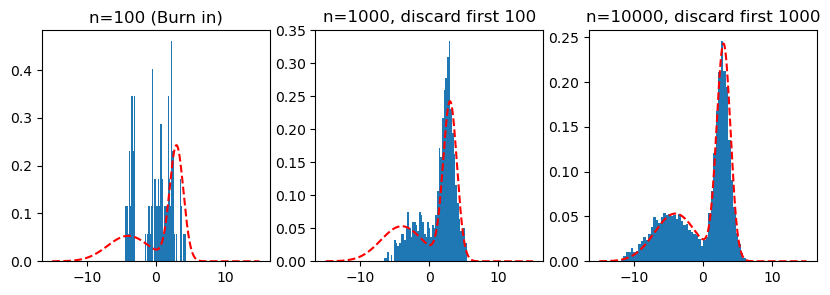

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10,3))
ax[0].hist(metropolis_samples[:100],50, density = True)
ax[0].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')
ax[1].hist(metropolis_samples[100:1000],50, density = True)
ax[1].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')
ax[2].hist(metropolis_samples[1000:],50, density = True)
ax[2].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')

ax[0].set_title("n=100 (Burn in)")
ax[1].set_title("n=1000, discard first 100")
ax[2].set_title("n=10000, discard first 1000")

plt.show()

We can also see how the Metropolis algorithm moves around the space with respect to time:

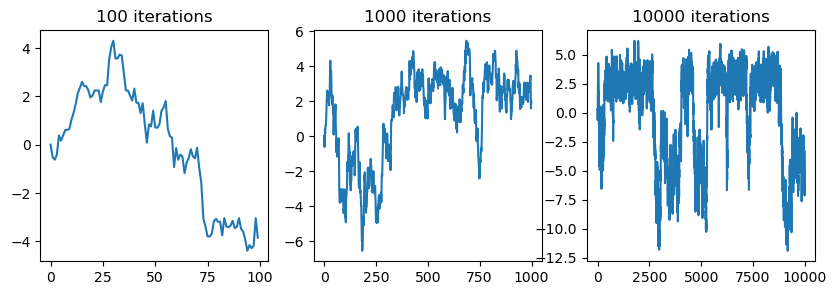

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10,3))
ax[0].plot(np.arange(len(metropolis_samples[:100])),metropolis_samples[:100])
ax[1].plot(np.arange(len(metropolis_samples[:1000])),metropolis_samples[:1000])
ax[2].plot(np.arange(len(metropolis_samples)),metropolis_samples)

ax[0].set_title("100 iterations")
ax[1].set_title("1000 iterations")
ax[2].set_title("10000 iterations")

plt.show()

**Remark (hyperparameters)**: We chose a Gaussian proposal distribution (which is symmetric), but the algorithm works better if the proposal distribution closely matches the shape of the target distribution. Additionally, note that we had hyperparameter $\epsilon$. Tuning this can strongly affect how the MCMC algorithm explores the solution space: If $\epsilon$ is very large, the algorithm will be more likely to land in regions of lower probability density and reject more often. If $\epsilon$ is very small, the chain may not fully explore the space in time. A good rule of thumb is to tune $\epsilon$ so that the algorithm accepts on the order of 30% of all samples (based on [this paper](https://projecteuclid.org/journals/annals-of-applied-probability/volume-7/issue-1/Weak-convergence-and-optimal-scaling-of-random-walk-Metropolis-algorithms/10.1214/aoap/1034625254.full)).

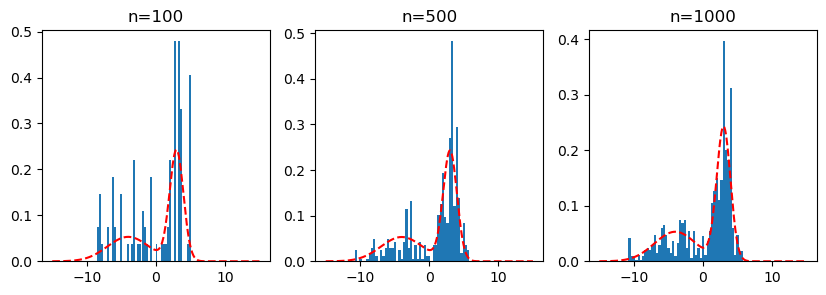

In [37]:
metropolis_samples = metropolis(0,10,1000, pdf)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10,3))
ax[0].hist(metropolis_samples[:100],50, density = True)
ax[0].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')
ax[1].hist(metropolis_samples[:500],50, density = True)
ax[1].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')
ax[2].hist(metropolis_samples, 50, density = True)
ax[2].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')

ax[0].set_title("n=100")
ax[1].set_title("n=500")
ax[2].set_title("n=1000")

plt.show()

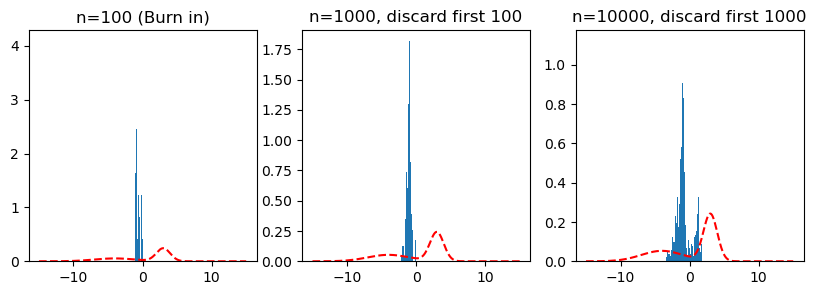

In [36]:
metropolis_samples = metropolis(0,0.1,1000, pdf)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10,3))
ax[0].hist(metropolis_samples[:100],50, density = True)
ax[0].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')
ax[1].hist(metropolis_samples[:500],50, density = True)
ax[1].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')
ax[2].hist(metropolis_samples,50, density = True)
ax[2].plot(np.linspace(-15,15,600),pdf(np.linspace(-15,15,600)),color='red', ls='--')

ax[0].set_title("n=100")
ax[1].set_title("n=500")
ax[2].set_title("n=1000")

plt.show()

**Remark (proportionality)**: Notice that the acceptance probability for a proposed point is $\frac{P(x')}{P(x)}$. This ratio means that we don't actually need to know the exact form of our target distribution $f$, we only need to know the form of $f$ up to a proportionality constant $f=Cg$, where the constant $C$ disappears in the ratio. This is one of the strengths of Metropolis Hastings.

## Demo: 2-Dimensional Metropolis, Gibbs Sampling

Let's do a multidimensional case now. Say we want to sample from $N(\mu,\Sigma)$, where $\mu=[0,0]^T$ and $\Sigma=\begin{bmatrix}1 & 0.5 \\ 0.5 & 1\end{bmatrix}$. We will use Gibbs sampling MCMC.

We primarily use Gibbs sampling when directly sampling from the joint distribution $P(x,y)$ is difficult, but sampling from each conditional distribution $P(x|y),P(y|x)$ is simple. The Biggs sampling algorithm is as follows:

1. Begin with initial value $X^0=(x_1,...,x_n)$
2. Given sample $X^t=(x^t_1,...,x^t_n)$, we obtain $X^{t+1}$ by sampling each component $x_i^{t+1}$ conditioned on all other components:
   $$P(x_j|x_1^{t+1},...,x_{j-1}^{t+1},x_{j+1}^t,...,x_n^t)$$
3. Once all components are sampled, we have new sample $X^{t+1}=(x_1^{t+1},...,x_n^{t+1})$

It can be shown that $p(x)p(x\to y)=p(y)p(y\to x)$, the detailed balance holds for Gibbs sampling. In fact Gibbs sampling is a special case of the Metropolis-Hastings algorithm.

For our example, it can be shown that given the distribution above, we can derive $P(x|y)\sim N(\rho y,1-\rho^2)=N(0.5y,0.75)$. Similarly, $P(y|x)\sim N(0.5x,0.75)$

In [40]:
def gibbs(x,y,n):
    x = x
    y = y
    sample = []
    for i in range(n):
        sample += [[x,y]]
        x = np.random.normal(.5*y,0.75)
        y = np.random.normal(.5*x,0.75)
    return sample

In [20]:
import pandas as pd
gibbs_sample = pd.DataFrame(gibbs(0,0,10000),columns = ["x","y"])

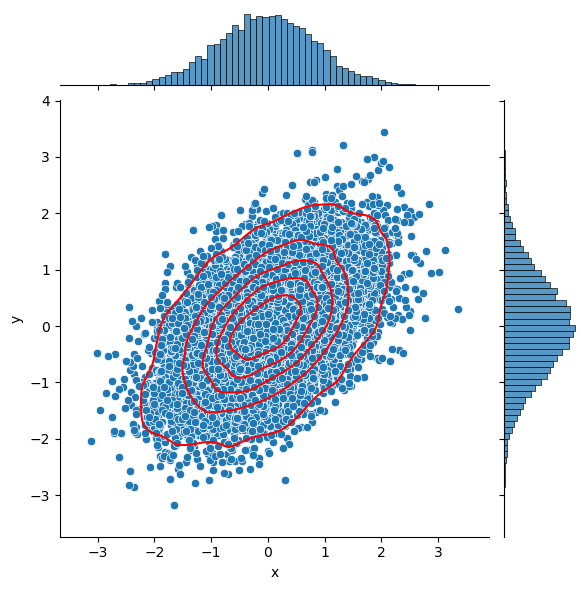

In [25]:
import seaborn as sns

g = sns.jointplot(data = gibbs_sample, x = "x", y = "y")
g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=6)
plt.show()

We can also see the traced path for Gibbs sampling:

In [22]:
# set up true MVN density for plotting
xx, yy = np.mgrid[-3:3:.05, -3:3:.05]
pos = np.dstack((xx, yy))
zz = sp.multivariate_normal.pdf(pos,[0,0],cov=[[1,.5],[.5,1]])

In [45]:
from matplotlib import animation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from IPython.display import HTML
from pathlib import Path
# direct matplotlib to ffmpeg executable, or add to path and skip
plt.rcParams['animation.ffmpeg_path'] = r'/sbin/anaconda3/bin/ffmpeg'
#plt.rcParams['animation.ffmpeg_path'] = r'C:\\ffmpeg\\bin\\ffmpeg.exe'

# use jshtml rendering, otherwise call HTML(ani.to_jshtml()) for ArtistAnimation and FuncAnimation
plt.rcParams['animation.html'] = 'jshtml'

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.tick_params(labelsize=14)
ims = []

for xx,yy in gibbs(0,0,5000):
    im = ax.scatter(xx,yy, s = 0.5)
    im = ax.plot(xx,yy, linewidth=0.2)
    ax.set_xlabel('X', fontsize=16)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_title('2D moving Gaussian', fontsize=20)


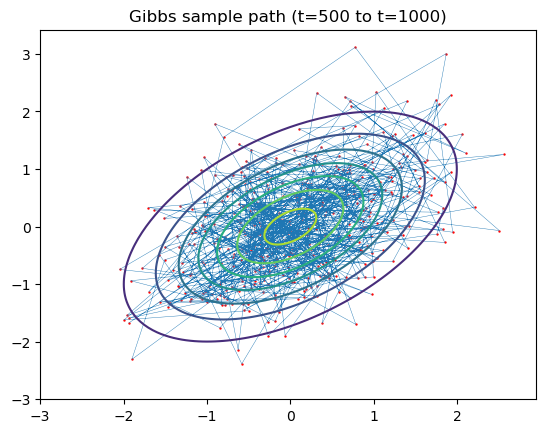

In [23]:
plt.scatter(gibbs_sample["x"][500:1000],gibbs_sample["y"][500:1000], s = 0.5, c = "red")
plt.plot(gibbs_sample["x"][500:1000],gibbs_sample["y"][500:1000], linewidth = 0.3)
plt.title("Gibbs sample path (t=500 to t=1000)")
plt.contour(xx,yy,zz)
plt.show()

Text(0.5, 1.0, '10000 iterations')

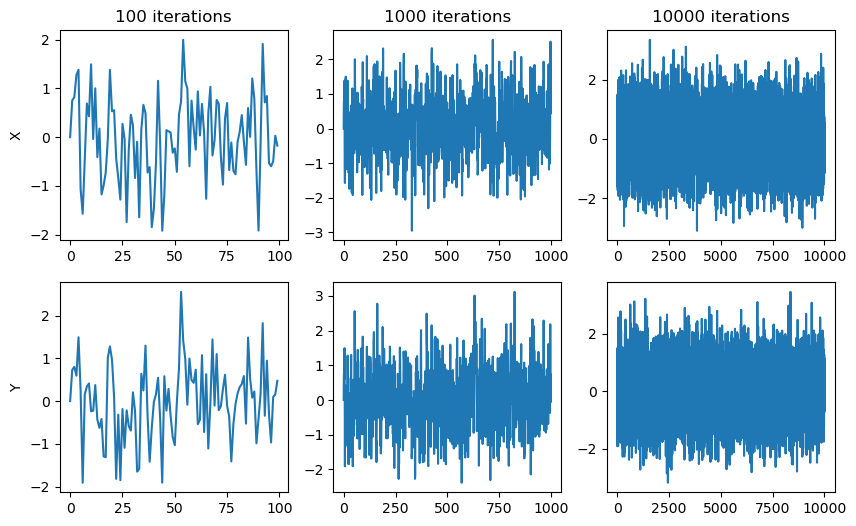

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (10,6))
ax[0,0].plot(np.arange(len(gibbs_sample["x"][:100])),gibbs_sample["x"][:100])
ax[0,1].plot(np.arange(len(gibbs_sample["x"][:1000])),gibbs_sample["x"][:1000])
ax[0,2].plot(np.arange(len(gibbs_sample["x"])),gibbs_sample["x"])
ax[1,0].plot(np.arange(len(gibbs_sample["y"][:100])),gibbs_sample["y"][:100])
ax[1,1].plot(np.arange(len(gibbs_sample["y"][:1000])),gibbs_sample["y"][:1000])
ax[1,2].plot(np.arange(len(gibbs_sample["y"])),gibbs_sample["y"])
ax[0,0].set_ylabel("X")
ax[1,0].set_ylabel("Y")

ax[0,0].set_title("100 iterations")
ax[0,1].set_title("1000 iterations")
ax[0,2].set_title("10000 iterations")


**Remark (strengths and weaknesses)**: The Gibbs sampler is popular because it does not require any tuning as in the case of MH. Additionally, it is a highly intuitive and simple way to sample in high-dimensional data. 

However, Gibbs sampling is slower than MH or other sampling methods because we must sample each component sequentially. Additionally, in high dimensional space, it can be difficult to determine convergence and accuracy of the Gibbs sampler.